In [40]:
# Reading data 
import pandas as pd 

In [39]:
import warnings;
warnings.filterwarnings('ignore');

**Assumptions:**


*   People visit that particular facility whose distance is minuimum to their zipcode location.
*   People with private insurance have 50% chances of undergoing surgery and those with government insurance have 100% chances.
* We are expecting the same no.of patients to undergo surgeries next year as well.










In [41]:
all_eye_df = pd.read_excel(r"Ambulatory_surgery_data.xlsx")
pop_centr_df = pd.read_csv(r"Utah_zipcode_population_centroid_lat_lng.csv")

In [42]:
#Removing duplicates in Record_ID field and NA values in Patient Zip code field
all_eye_df = all_eye_df.drop_duplicates(subset=["RECORD_ID"], keep="last")

In [43]:
all_eye_df["PATIENT_ZIP_CODE"] = all_eye_df["PATIENT_ZIP_CODE"].dropna().astype(int)

In [44]:
#Filtering the data for surgery flags 1,2 as 0 indicates NO surgery
surgery_df = all_eye_df[all_eye_df["SURG_FLAG"].isin([1, 2])]

In [45]:
surgery_df.head()

,RECORD_ID,AGE_GROUP,PATIENT_ZIP_CODE,PATIENT_COUNTY,PATIENT_STATE,PATIENT_GENDER,FACILITY_ID,FACILITY_NAME,FACILITY_AFF,FACILITY_OWNERSHIP,FACILITY_LAT,FACILITY_LNG,FACILITY_ZIP_CODE,X_PAYER_PRIMARY_TYPOLOGY,OPTUM_SERVICE_LINE,OPTUM_SUBSERVICE_LINE,OPTUM_PROCEDURE_GROUP,SURG_FLAG
686,393663541,85 - 89,84124.0,Salt Lake County,UT,F,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,40.771473,-111.837311,84132,1.0,Ophthalmology,Glaucoma Procedures,Laser Repair - Trabeculoplasty,2
799,393261206,1 - 4,84651.0,Utah County,UT,M,122,Primary Childrens Hospital,Primary Childrens Hospital,INTERMOUNTAIN HEALTHCARE,40.771285,-111.838811,84113,6.0,Ophthalmology,Other Eye Procedures,Exploratory Surgery - Orbit,1
1734,394083626,65 - 69,84096.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,40.771473,-111.837311,84132,6.0,Ophthalmology,Eyelid Procedures,Lesion Destruction/Excision - Eyelid,1
1739,393648845,55 - 59,84009.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,40.771473,-111.837311,84132,6.0,Ophthalmology,Cataract Procedures,Secondary Cataract Laser Surgery (Yag Capsulot...,2
2016,394385694,65 - 69,84096.0,Salt Lake County,UT,F,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,40.771473,-111.837311,84132,1.0,Ophthalmology,Vitreo-Retinal Procedures,Injection - Vitreous,2


In [46]:
pop_centr_df.index = pop_centr_df["ZIP_CODE"]

In [47]:
#Mapping zipcode with their respective latitudes and longitudes
lat_map = pop_centr_df["LATITUDE"].to_dict()
log_map = pop_centr_df["LONGITUDE"].to_dict()

surgery_df.loc[:, "PATIENT_HOME_LAT"] = surgery_df["PATIENT_ZIP_CODE"].map(lat_map)
surgery_df.loc[:, "PATIENT_HOME_LOG"] = surgery_df["PATIENT_ZIP_CODE"].map(log_map)

In [48]:
import numpy as np

#Defining a function to calculate the Haversine distance which
#determines the great-circle distance between two points on a sphere given their longitudes and latitudes
def haversine(x, to_radians=True, earth_radius=6371):
    lat1, lon1, lat2, lon2 = x
    
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [49]:
#Creating a new column FAC_HOME_DIST to find the distance between 
#patient's current homelocation and facility location he/she is currently travelling
surgery_df.loc[:, "FAC_HOME_DIST"] = surgery_df[["FACILITY_LAT", "FACILITY_LNG", "PATIENT_HOME_LAT", "PATIENT_HOME_LOG"]].T.apply(haversine)

In [50]:
#Defining functions to calculate the Haversine distances between Patient located latitude,longitude and
# if a facility is established in Farmington and 3 zipcodes of South Jordan respectively
def haversine_farmington(x, lat1=40.9805, lon1=-111.887439, to_radians=True, earth_radius=6371):
    lat2, lon2 = x
    return haversine((lat1, lon1, lat2, lon2))

def haversine_south_jordan_95(x, lat1=40.56217, lon1=-111.929658, to_radians=True, earth_radius=6371):
    lat2, lon2 = x
    return haversine((lat1, lon1, lat2, lon2))

def haversine_south_jordan_06(x, lat1=40.564669, lon1=-112.097441, to_radians=True, earth_radius=6371):
    lat2, lon2 = x
    return haversine((lat1, lon1, lat2, lon2))

def haversine_south_jordan_09(x, lat1=40.562296, lon1=-111.999829, to_radians=True, earth_radius=6371):
    lat2, lon2 = x
    return haversine((lat1, lon1, lat2, lon2))

In [51]:
#Creating new columns which have the Haversine distance between Patient located latitude,longitude and
#the latitudes,longitudes of facility location if a facility is established in Farmington and 
#3 zipcodes of South Jordan respectively

surgery_df.loc[:, "FARM_HOME_DIST"] = surgery_df[["PATIENT_HOME_LAT", "PATIENT_HOME_LOG"]].T.apply(haversine_farmington)
surgery_df.loc[:, "SJ95_HOME_DIST"] = surgery_df[["PATIENT_HOME_LAT", "PATIENT_HOME_LOG"]].T.apply(haversine_south_jordan_95)
surgery_df.loc[:, "SJ06_HOME_DIST"] = surgery_df[["PATIENT_HOME_LAT", "PATIENT_HOME_LOG"]].T.apply(haversine_south_jordan_06)
surgery_df.loc[:, "SJ09_HOME_DIST"] = surgery_df[["PATIENT_HOME_LAT", "PATIENT_HOME_LOG"]].T.apply(haversine_south_jordan_09)


In [52]:
gov_ins_tot = surgery_df["X_PAYER_PRIMARY_TYPOLOGY"].isin([1,2,3,4]).sum()
pvt_ins_tot = surgery_df["X_PAYER_PRIMARY_TYPOLOGY"].isin([5,6]).sum()

In [53]:
#Assigning weights as 0.5 for private insurance and 1 for govt insurance
#def insurance(x):
   # if x == 5:
      #  return 0.5
    #else:
        #return 1
    
#surgery_df.loc[:, "INSURANCE"] = surgery_df["X_PAYER_PRIMARY_TYPOLOGY"].apply(insurance)


def insurance(x):
    if x == 5 or x == 6:
        return 0.5
    elif x == 8 or x == 9 or np.isnan(x):
        tot_ins = gov_ins_tot + pvt_ins_tot
        return (pvt_ins_tot/tot_ins)*0.5 + (gov_ins_tot/tot_ins)*1
    else:
        return 1
    
surgery_df.loc[:, "INSURANCE"] = surgery_df["X_PAYER_PRIMARY_TYPOLOGY"].apply(insurance)

In [54]:
#Defining a function and calculating the minimum distance between the current facility location
#and if a facility is established in Farmington
def func(x):
    c = ["FAC_HOME_DIST", "FARM_HOME_DIST"]
    return c[np.argmin(x)]

surgery_df.loc[:, "BEST_FAC_FARM"] = surgery_df[["FAC_HOME_DIST", "FARM_HOME_DIST"]].T.apply(func)

In [55]:
#Defining a function and calculating the minimum distance between the current facility location
#and if a facility is established in SouthJordan 84095
def func(x):
    c = ["FAC_HOME_DIST", "SJ95_HOME_DIST"]
    return c[np.argmin(x)]

surgery_df.loc[:, "BEST_FAC_SJ95"] = surgery_df[["FAC_HOME_DIST", "SJ95_HOME_DIST"]].T.apply(func)

In [56]:
#Defining a function and calculating the minimum distance between the current facility location
#and if a facility is established in SouthJordan 84006
def func(x):
    c = ["FAC_HOME_DIST", "SJ06_HOME_DIST"]
    return c[np.argmin(x)]

surgery_df.loc[:, "BEST_FAC_SJ06"] = surgery_df[["FAC_HOME_DIST", "SJ06_HOME_DIST"]].T.apply(func)



In [57]:
#Defining a function and calculating the minimum distance between the current facility location
#and if a facility is established in SouthJordan 84009
def func(x):
    c = ["FAC_HOME_DIST", "SJ09_HOME_DIST"]
    return c[np.argmin(x)]

surgery_df.loc[:, "BEST_FAC_SJ09"] = surgery_df[["FAC_HOME_DIST", "SJ09_HOME_DIST"]].T.apply(func)



In [58]:
#Defining a function and calculating the minimum distance between the current facility location
#and if a facility is established both in Farmington and SouthJordan 84095
def func(x):
    c = ["FAC_HOME_DIST", "FARM_HOME_DIST", "SJ95_HOME_DIST"]
    return c[np.argmin(x)]

surgery_df.loc[:, "BEST_FARM_SJ95"] = surgery_df[["FAC_HOME_DIST", "FARM_HOME_DIST", "SJ95_HOME_DIST"]].T.apply(func)


In [59]:
# Add wasatch front regions to zip codes 

region_zip_df = pd.read_excel(r"U Health Markets by zipcode 2020-04-09.xlsx")

region_zip_df.index = region_zip_df["Zip"]
reg_zip_map = region_zip_df["Macro Market"].to_dict()

surgery_df["REGION"] = surgery_df["FACILITY_ZIP_CODE"].map(reg_zip_map)
surgery_df["WASATCH FRONT"] = surgery_df["REGION"] == "Utah - Wasatch Front"

In [60]:
#Filtering the data to include only facilities in the Wasatch Front
surgery_df = surgery_df[surgery_df["WASATCH FRONT"]]


In [61]:
#Extracting the data after filtering,transforming to an excel sheet
surgery_df.to_excel(r"surgery_enhanced_df.xlsx")

*** Drawing insights after cleaning the data and making necessary transformations***

In [62]:
surgery_df[surgery_df["WASATCH FRONT"] == True]["FAC_HOME_DIST"].mean()

25.56263139856934

In [63]:
surgery_df[surgery_df["WASATCH FRONT"] == True]["FAC_HOME_DIST"].std()

45.76546084440613

So people are travelling around 25.5 kms on average for surgery with a standard deviation of 49 kms

In [64]:
# insights 
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# Calculating the no.of surgeries handled by Univeristy of Utah Health and non-Univ of Utah Health facilities
u_utah_counts = surgery_df[surgery_df["FACILITY_AFF"] == "University of Utah Health"]["FACILITY_ZIP_CODE"].value_counts()

other_utah_counts = surgery_df[surgery_df["FACILITY_AFF"] != "University of Utah Health"]["FACILITY_ZIP_CODE"].value_counts()


In [66]:
#No.of surgeries handled by Univeristy of Utah Health facility
u_utah_counts.sum()

14803

In [67]:
#No.of surgeries handled by Non-Univeristy of Utah Health facilities
other_utah_counts.sum()

24481

***Zipcode wise surgeries plot***

Text(0.5, 1.0, 'No.of surgeries taking place in each Zipcode')

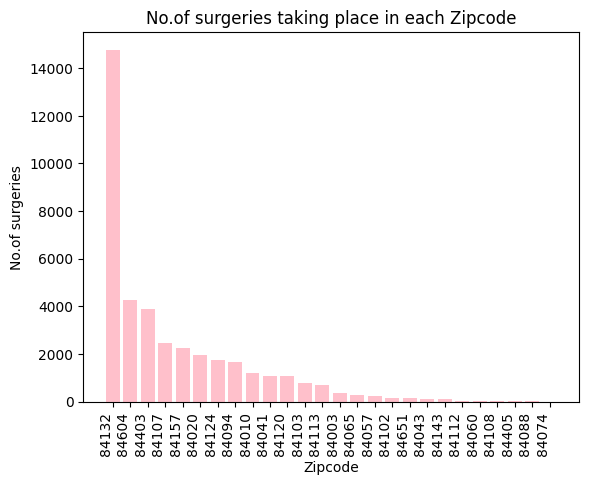

In [68]:
plt.xticks(rotation=90, ha='right')
plt.bar(surgery_df["FACILITY_ZIP_CODE"].value_counts().index.astype(str), surgery_df["FACILITY_ZIP_CODE"].value_counts().values,color = 'Pink')
plt.xlabel("Zipcode")
plt.ylabel("No.of surgeries")
plt.title("No.of surgeries taking place in each Zipcode")

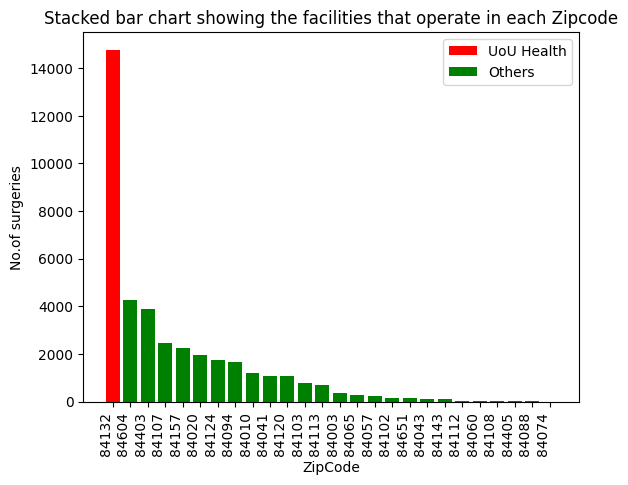

In [69]:
plt.xticks(rotation=90, ha='right')

x = surgery_df["FACILITY_ZIP_CODE"].value_counts().index
y_l1 = u_utah_counts.to_dict()
y_l2 = other_utah_counts.to_dict()

y1, y2 = [], []
for zc in x:
    if zc in y_l1:
        y1.append(y_l1[zc])
    else:
        y1.append(0)
        
    if zc in y_l2:
        y2.append(y_l2[zc])
    else:
        y2.append(0)
    
x = x.astype(str)
plt.bar(x, y1, label="UoU Health",color = "Red")
plt.bar(x, y2, label="Others",color="Green")
plt.xlabel("ZipCode")
plt.ylabel("No.of surgeries")
plt.title("Stacked bar chart showing the facilities that operate in each Zipcode")
plt.legend()

By the above 2 plots we can notice that the maximum no.of surgeries take place in 84132 ( Salt Lake, Salt Lake County,Utah- Wasatch Front) and the Univeristy of Utah Health manages all the surgeries in this zipcode.

Text(0.5, 1.0, 'Bar chart showing Cumulative sum of percentage of market share for Non UoU Health facilities for each Zipcode')

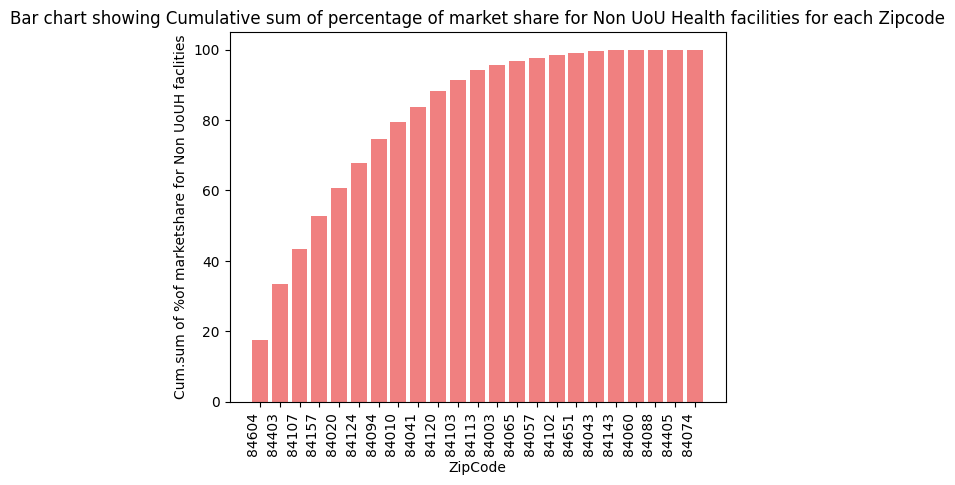

In [70]:
plt.xticks(rotation=90, ha='right')
plt.bar(other_utah_counts.index.astype(str), (np.cumsum(other_utah_counts)/np.sum(other_utah_counts)*100),color = "lightcoral")
plt.xlabel("ZipCode")
plt.ylabel("Cum.sum of %of marketshare for Non UoUH faclities")
plt.title("Bar chart showing Cumulative sum of percentage of market share for Non UoU Health facilities for each Zipcode")

From the above plot we can infer that UoU health can capture more than 50% of Non-Univ of Utah health market share if it focuses on the 4 zipcodes in above plot i.e 84604, 84403, 84107, 84157. The zipcodes in above plot are currently not managed by UoU Health

# What do we observe if a facility is established in Farmington 84025:



In [71]:
farm_capture_df = surgery_df[surgery_df["BEST_FAC_FARM"] == "FARM_HOME_DIST"]
#sj_zip_count_95 = sj_capture_df_95["FACILITY_ZIP_CODE"].value_counts()
farm_zip_count = farm_capture_df["FACILITY_ZIP_CODE"].value_counts()

Text(0.5, 1.0, 'No.of surgeries taking place in each Zipcode if we start a facility in Farmington')

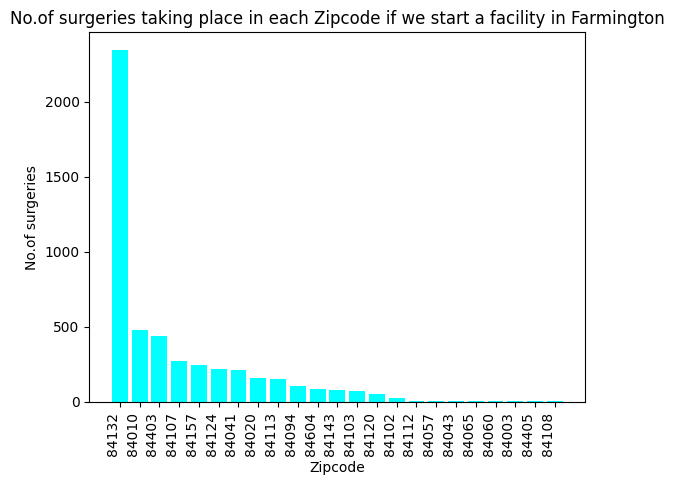

In [72]:
plt.xticks(rotation=90, ha='right')
plt.bar(farm_capture_df["FACILITY_ZIP_CODE"].value_counts().index.astype(str), farm_capture_df["FACILITY_ZIP_CODE"].value_counts().values,color = "cyan")
plt.xlabel("Zipcode")
plt.ylabel("No.of surgeries")
plt.title("No.of surgeries taking place in each Zipcode if we start a facility in Farmington")


In [73]:
farm_tot = farm_capture_df.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the Farmington Facility are - {}".format(int(farm_tot)))

Total number of expected surgeries in the Farmington Facility are - 3991


** Total number of expected surgeries if a facility is established in Farmington - 3991

In [74]:
farm_capture_df.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False)[1:].sum()


INSURANCE    1985.302611
dtype: float64

** No.of additional surgeries we can expect from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in Farmington - 2037

In [75]:
print("Additional percentage captured by adding a new facility in Farmington - {} %".format(round(1985*100/24481, 2)))

Additional percentage captured by adding a new facility in Farmington - 8.11 %


**So the additional percentage of market share that can be captured from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in Farmington - 8.11%**


# What do we observe if a facility is established in South Jordan 84095:

In [76]:
sj_capture_df_95 = surgery_df[surgery_df["BEST_FAC_SJ95"] == "SJ95_HOME_DIST"]
sj_zip_count_95 = sj_capture_df_95["FACILITY_ZIP_CODE"].value_counts()
sj_capture_df_95

,RECORD_ID,AGE_GROUP,PATIENT_ZIP_CODE,PATIENT_COUNTY,PATIENT_STATE,PATIENT_GENDER,FACILITY_ID,FACILITY_NAME,FACILITY_AFF,FACILITY_OWNERSHIP,...,SJ06_HOME_DIST,SJ09_HOME_DIST,INSURANCE,BEST_FAC_FARM,BEST_FAC_SJ95,BEST_FAC_SJ06,BEST_FAC_SJ09,BEST_FARM_SJ95,REGION,WASATCH FRONT
799,393261206,1 - 4,84651.0,Utah County,UT,M,122,Primary Childrens Hospital,Primary Childrens Hospital,INTERMOUNTAIN HEALTHCARE,...,66.942634,63.283152,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1734,394083626,65 - 69,84096.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1739,393648845,55 - 59,84009.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,7.929558,0.881971,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2016,394385694,65 - 69,84096.0,Salt Lake County,UT,F,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2244,393396868,45 - 49,84020.0,Salt Lake County,UT,F,416,Moran,University of Utah Health,NaN,...,20.057447,12.348157,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118762,394817494,50 - 54,84020.0,Salt Lake County,UT,F,422,Utah Surgical Center,HCA Mountainstar,NUETERRA,...,20.057447,12.348157,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118771,393231361,60 - 64,84020.0,Salt Lake County,UT,F,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,20.057447,12.348157,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118773,393227055,65 - 69,84065.0,Salt Lake County,UT,M,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,14.565213,7.910693,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118774,393225177,80 - 84,84094.0,Salt Lake County,UT,M,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,19.872752,11.677286,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True


Text(0.5, 1.0, 'No.of surgeries taking place in each Zipcode if we start a facility in South Jordan 84095')

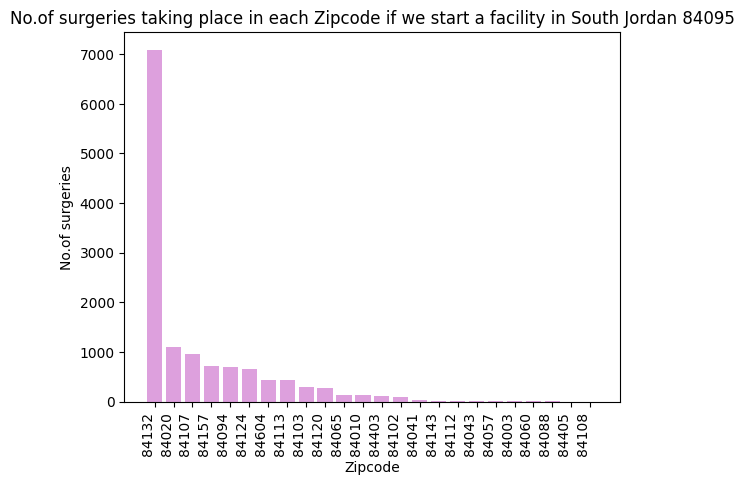

In [77]:
plt.xticks(rotation=90, ha='right')
plt.bar(sj_zip_count_95.index.astype(str), sj_zip_count_95.values,color="plum")
plt.xlabel("Zipcode")
plt.ylabel("No.of surgeries")
plt.title("No.of surgeries taking place in each Zipcode if we start a facility in South Jordan 84095")

In [78]:
sj_tot_95 = sj_capture_df_95.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the South Jordan Facility are - {}".format(int(sj_tot_95)))

Total number of expected surgeries in the South Jordan Facility are - 10647


** Total number of expected surgeries if a facility is established in South Jordan84095 - 10647

In [79]:
sj_capture_df_95.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False)[1:].sum()


INSURANCE    4595.363012
dtype: float64

** No.of additional surgeries we can expect from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in South Jordan 84095 are 4775.

In [80]:
print("Additional percentage captured by adding a new facility in South Jordan 84095 - {} %".format(round(4595*100/24481, 2)))

Additional percentage captured by adding a new facility in South Jordan 84095 - 18.77 %


**So the additional percentage of market share that can be captured from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in South Jordan 84095 is 18.77%**

# What do we observe if a facility is established in South Jordan 84006:

In [81]:
sj_capture_df_06 = surgery_df[surgery_df["BEST_FAC_SJ06"] == "SJ06_HOME_DIST"]
sj_zip_count_06 = sj_capture_df_06["FACILITY_ZIP_CODE"].value_counts()
sj_capture_df_06

,RECORD_ID,AGE_GROUP,PATIENT_ZIP_CODE,PATIENT_COUNTY,PATIENT_STATE,PATIENT_GENDER,FACILITY_ID,FACILITY_NAME,FACILITY_AFF,FACILITY_OWNERSHIP,...,SJ06_HOME_DIST,SJ09_HOME_DIST,INSURANCE,BEST_FAC_FARM,BEST_FAC_SJ95,BEST_FAC_SJ06,BEST_FAC_SJ09,BEST_FARM_SJ95,REGION,WASATCH FRONT
799,393261206,1 - 4,84651.0,Utah County,UT,M,122,Primary Childrens Hospital,Primary Childrens Hospital,INTERMOUNTAIN HEALTHCARE,...,66.942634,63.283152,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1734,394083626,65 - 69,84096.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1739,393648845,55 - 59,84009.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,7.929558,0.881971,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2016,394385694,65 - 69,84096.0,Salt Lake County,UT,F,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2244,393396868,45 - 49,84020.0,Salt Lake County,UT,F,416,Moran,University of Utah Health,NaN,...,20.057447,12.348157,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118759,393627976,25 - 29,84532.0,Grand County,UT,F,416,Moran,University of Utah Health,NaN,...,313.656265,307.618562,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118762,394817494,50 - 54,84020.0,Salt Lake County,UT,F,422,Utah Surgical Center,HCA Mountainstar,NUETERRA,...,20.057447,12.348157,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118771,393231361,60 - 64,84020.0,Salt Lake County,UT,F,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,20.057447,12.348157,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118773,393227055,65 - 69,84065.0,Salt Lake County,UT,M,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,14.565213,7.910693,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True


Text(0.5, 1.0, 'No.of surgeries taking place in each Zipcode if we start a facility in South Jordan 84006')

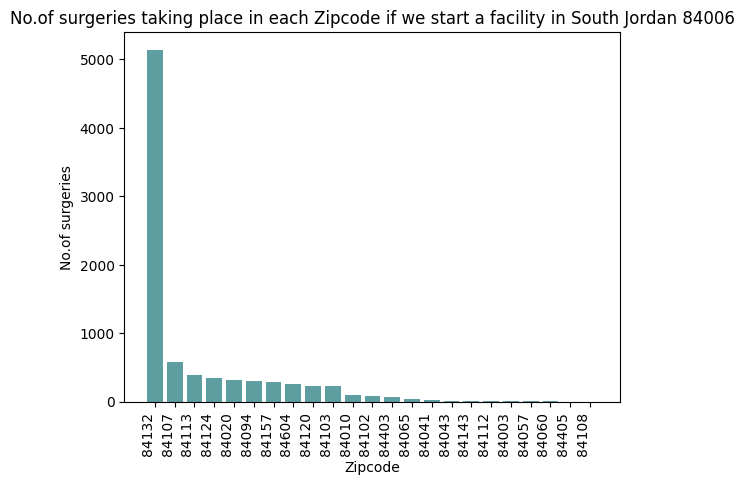

In [82]:
plt.xticks(rotation=90, ha='right')
plt.bar(sj_zip_count_06.index.astype(str), sj_zip_count_06.values,color="cadetblue")
plt.xlabel("Zipcode")
plt.ylabel("No.of surgeries")
plt.title("No.of surgeries taking place in each Zipcode if we start a facility in South Jordan 84006")

In [83]:
sj_tot_06 = sj_capture_df_06.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the South Jordan 06 Facility are - {}".format(int(sj_tot_06)))

Total number of expected surgeries in the South Jordan 06 Facility are - 6768


** Total number of expected surgeries if a facility is established in South Jordan84006 - 6768

In [84]:
sj_capture_df_06.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False)[1:].sum()


INSURANCE    2413.05309
dtype: float64

** No.of additional surgeries we can expect from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in South Jordan 84006 are 2504.

In [85]:
print("Additional percentage captured by adding a new facility in South Jordan 84006 - {} %".format(round(2413*100/24481, 2)))

Additional percentage captured by adding a new facility in South Jordan 84006 - 9.86 %


**So the additional percentage of market share that can be captured from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in South Jordan 84006 is 9.86%**

# What do we observe if a facility is established in South Jordan 84009:

In [86]:
sj_capture_df_09 = surgery_df[surgery_df["BEST_FAC_SJ09"] == "SJ09_HOME_DIST"]
sj_zip_count_09 = sj_capture_df_09["FACILITY_ZIP_CODE"].value_counts()
sj_capture_df_09

,RECORD_ID,AGE_GROUP,PATIENT_ZIP_CODE,PATIENT_COUNTY,PATIENT_STATE,PATIENT_GENDER,FACILITY_ID,FACILITY_NAME,FACILITY_AFF,FACILITY_OWNERSHIP,...,SJ06_HOME_DIST,SJ09_HOME_DIST,INSURANCE,BEST_FAC_FARM,BEST_FAC_SJ95,BEST_FAC_SJ06,BEST_FAC_SJ09,BEST_FARM_SJ95,REGION,WASATCH FRONT
799,393261206,1 - 4,84651.0,Utah County,UT,M,122,Primary Childrens Hospital,Primary Childrens Hospital,INTERMOUNTAIN HEALTHCARE,...,66.942634,63.283152,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1734,394083626,65 - 69,84096.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1739,393648845,55 - 59,84009.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,7.929558,0.881971,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2016,394385694,65 - 69,84096.0,Salt Lake County,UT,F,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2244,393396868,45 - 49,84020.0,Salt Lake County,UT,F,416,Moran,University of Utah Health,NaN,...,20.057447,12.348157,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118759,393627976,25 - 29,84532.0,Grand County,UT,F,416,Moran,University of Utah Health,NaN,...,313.656265,307.618562,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118762,394817494,50 - 54,84020.0,Salt Lake County,UT,F,422,Utah Surgical Center,HCA Mountainstar,NUETERRA,...,20.057447,12.348157,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118771,393231361,60 - 64,84020.0,Salt Lake County,UT,F,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,20.057447,12.348157,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118773,393227055,65 - 69,84065.0,Salt Lake County,UT,M,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,14.565213,7.910693,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True


Text(0.5, 1.0, 'No.of surgeries taking place in each Zipcode if we start a facility in South Jordan 84009')

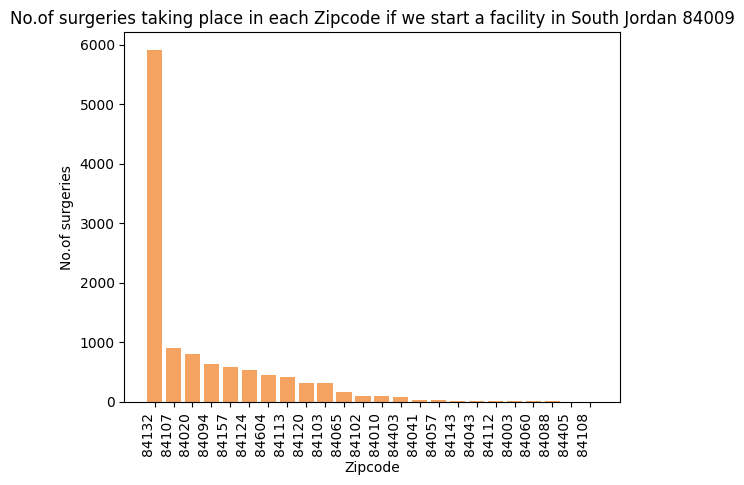

In [87]:
plt.xticks(rotation=90, ha='right')
plt.bar(sj_zip_count_09.index.astype(str), sj_zip_count_09.values,color="sandybrown")
plt.xlabel("Zipcode")
plt.ylabel("No.of surgeries")
plt.title("No.of surgeries taking place in each Zipcode if we start a facility in South Jordan 84009")

In [88]:
sj_tot_09 = sj_capture_df_09.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the South Jordan Facility are - {}".format(int(sj_tot_09)))

Total number of expected surgeries in the South Jordan Facility are - 9075


** Total number of expected surgeries if a facility is established in South Jordan84009 - 9075

In [89]:
sj_capture_df_09.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False)[1:].sum()


INSURANCE    4055.892255
dtype: float64

** No.of additional surgeries we can expect from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in South Jordan 84009 are 4055.

In [90]:
print("Additional percentage captured by adding a new facility in South Jordan 84009 - {} %".format(round(4055.89*100/24481, 2)))

Additional percentage captured by adding a new facility in South Jordan 84009 - 16.57 %


So the additional percentage of market share that can be captured from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in South Jordan 84009 is 16.57%

*** From the above observations it is clear that among the 3 zipcodes in SouthJordan we can capture more Non-UoU Health market if we establish a facility at South Jordan zipcode of 84095.***

# What do we observe if a facility is established in both Farmington and South Jordan 84095:

In [91]:
farm_sj_capture_df = surgery_df[surgery_df["BEST_FARM_SJ95"].isin(["SJ95_HOME_DIST", "FARM_HOME_DIST"])]
farm_sj_zip_count = farm_sj_capture_df["FACILITY_ZIP_CODE"].value_counts()
farm_sj_capture_df

,RECORD_ID,AGE_GROUP,PATIENT_ZIP_CODE,PATIENT_COUNTY,PATIENT_STATE,PATIENT_GENDER,FACILITY_ID,FACILITY_NAME,FACILITY_AFF,FACILITY_OWNERSHIP,...,SJ06_HOME_DIST,SJ09_HOME_DIST,INSURANCE,BEST_FAC_FARM,BEST_FAC_SJ95,BEST_FAC_SJ06,BEST_FAC_SJ09,BEST_FARM_SJ95,REGION,WASATCH FRONT
799,393261206,1 - 4,84651.0,Utah County,UT,M,122,Primary Childrens Hospital,Primary Childrens Hospital,INTERMOUNTAIN HEALTHCARE,...,66.942634,63.283152,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1734,394083626,65 - 69,84096.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
1739,393648845,55 - 59,84009.0,Salt Lake County,UT,M,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,7.929558,0.881971,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2016,394385694,65 - 69,84096.0,Salt Lake County,UT,F,125,Univ Hosp. | Clinics,University of Utah Health,UNIVERSITY OF UTAH HEALTH CARE,...,9.208881,6.446068,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
2186,393583110,35 - 39,84015.0,Davis County,UT,F,416,Moran,University of Utah Health,NaN,...,61.770662,61.949442,1.0,FARM_HOME_DIST,FAC_HOME_DIST,FAC_HOME_DIST,FAC_HOME_DIST,FARM_HOME_DIST,Utah - Wasatch Front,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118770,394826621,1 - 4,84025.0,Davis County,UT,F,424,Mountain West Surgery Center,HCA Mountainstar,NUETERRA,...,49.421910,47.625378,0.5,FARM_HOME_DIST,FAC_HOME_DIST,FAC_HOME_DIST,FAC_HOME_DIST,FARM_HOME_DIST,Utah - Wasatch Front,True
118771,393231361,60 - 64,84020.0,Salt Lake County,UT,F,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,20.057447,12.348157,0.5,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118773,393227055,65 - 69,84065.0,Salt Lake County,UT,M,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,14.565213,7.910693,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True
118774,393225177,80 - 84,84094.0,Salt Lake County,UT,M,120,Salt Lake Regional Medical Center,Steward Healthcare,"SALT LAKE REGIONAL MEDICAL, LP",...,19.872752,11.677286,1.0,FAC_HOME_DIST,SJ95_HOME_DIST,SJ06_HOME_DIST,SJ09_HOME_DIST,SJ95_HOME_DIST,Utah - Wasatch Front,True


Text(0.5, 1.0, 'No.of surgeries taking place in each Zipcode if we start a facility in Farmington&South Jordan 84095')

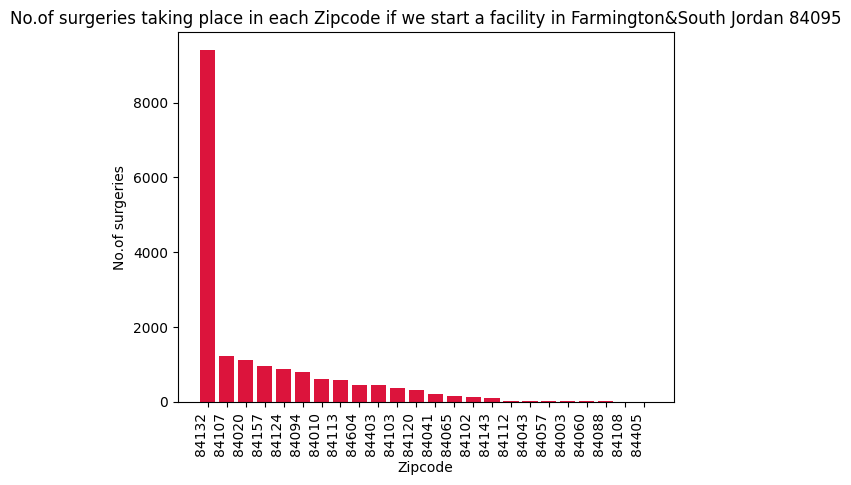

In [92]:
plt.xticks(rotation=90, ha='right')
plt.bar(farm_sj_zip_count.index.astype(str), farm_sj_zip_count.values,color="crimson")
plt.xlabel("Zipcode")
plt.ylabel("No.of surgeries")
plt.title("No.of surgeries taking place in each Zipcode if we start a facility in Farmington&South Jordan 84095")

In [93]:
farm_sj_capture_df.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False)[1:].sum()


INSURANCE    6285.062316
dtype: float64

** No.of additional surgeries we can expect from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in both Farmington and South Jordan84095 are 6285.

In [94]:
print("Additional percentage captured by adding a new facility in Farmington and South Jordan - {} %".format(round(6285*100/24481, 2)))

Additional percentage captured by adding a new facility in Farmington and South Jordan - 25.67 %


**So the additional percentage of market share that can be captured from the zipcodes that are currently dominated by Non-UoU health facilities if we establish a facility in both Farmington and South Jordan84095 is 25.67%**

Answering the questions given:

In [95]:
#Q1:
surgery_df[surgery_df["WASATCH FRONT"] == True]["FAC_HOME_DIST"].mean()

25.56263139856934

In [96]:
surgery_df[surgery_df["WASATCH FRONT"] == True]["FAC_HOME_DIST"].std()

45.76546084440613

In [97]:
#Q1a:

Based on the analysis, we can define Farmington 84025 and SouthJordan 84095 as the eye surgery markets.

In [98]:
#Q2:

In [99]:
farm_tot = farm_capture_df.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the Farmington Facility are - {}".format(int(farm_tot)))

Total number of expected surgeries in the Farmington Facility are - 3991


In [100]:
sj_tot_06 = sj_capture_df_06.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the South Jordan 84006 Facility are - {}".format(int(sj_tot_06)))

Total number of expected surgeries in the South Jordan 84006 Facility are - 6768


In [101]:
sj_tot_09 = sj_capture_df_09.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the South Jordan 84009 Facility are - {}".format(int(sj_tot_09)))

Total number of expected surgeries in the South Jordan 84009 Facility are - 9075


In [102]:
sj_tot_95 = sj_capture_df_95.groupby("FACILITY_ZIP_CODE").agg({"INSURANCE" : sum}).sort_values(by="INSURANCE", ascending=False).sum()[0]

print("Total number of expected surgeries in the South Jordan 84095 Facility are - {}".format(int(sj_tot_95)))

Total number of expected surgeries in the South Jordan 84095 Facility are - 10647


In [103]:
#Q2a:

In [104]:
zip_df = surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84025]
print("Percentage of insurance access to U health services for Farmington is {}".format(zip_df["INSURANCE"].sum()/zip_df["INSURANCE"].shape[0]*100))

Percentage of insurance access to U health services for Farmington is 84.1438319385845


In [105]:
zip_df = surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84006]
print("Percentage of insurance access to U health services for South Jordan 84006 is {}".format(zip_df["INSURANCE"].sum()/zip_df["INSURANCE"].shape[0]*100))

Percentage of insurance access to U health services for South Jordan 84006 is 100.0


In [106]:
zip_df = surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84009]
print("Percentage of insurance access to U health services for South Jordan 84009 is {}".format(zip_df["INSURANCE"].sum()/zip_df["INSURANCE"].shape[0]*100))

Percentage of insurance access to U health services for South Jordan 84009 is 79.46805520361497


In [107]:
zip_df = surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84095]
print("Percentage of insurance access to U health services for South Jordan 84095 is {}".format(zip_df["INSURANCE"].sum()/zip_df["INSURANCE"].shape[0]*100))

Percentage of insurance access to U health services for South Jordan 84095 is 81.04486994273823


In [108]:
#Q3:

In [109]:
farm_capture_df = surgery_df[surgery_df["BEST_FAC_FARM"] == "FARM_HOME_DIST"]
# all markets
u_zips = list(farm_capture_df["PATIENT_ZIP_CODE"].dropna().unique())

z_vals = []
for z in u_zips:
    z_vals.append(farm_capture_df[farm_capture_df["PATIENT_ZIP_CODE"] == z]["INSURANCE"].sum()/surgery_df[surgery_df["PATIENT_ZIP_CODE"] == z].shape[0])
    
sorted_zips_vals = sorted(zip(u_zips, z_vals), key=lambda x: x[1])
u_zips = [x[0] for x in sorted_zips_vals]
z_vals = [x[1] for x in sorted_zips_vals]


In [110]:
from tabulate import tabulate

table1 = sorted(zip(u_zips , z_vals), key=lambda x: x[1], reverse=True)
headers1 = ["ZIP Code", "Insurance Coverage (%)"]
print(tabulate(table1[:20], headers=headers1))



  ZIP Code    Insurance Coverage (%)
----------  ------------------------
     84038                  1
     84334                  1
     84306                  1
     84147                  1
     84033                  0.909091
     84018                  0.875
     84083                  0.8701
     84050                  0.867175
     84037                  0.846677
     84025                  0.841438
     84327                  0.833333
     84341                  0.791545
     84335                  0.77644
     84332                  0.759192
     84320                  0.754759
     84011                  0.635112
     84321                  0.618895
     84339                  0.613236
     84415                  0.6
     84016                  0.6


U health's eye surgery market share for Farmington 84025 is 0.841438

In [111]:
farm_capture_df = surgery_df[surgery_df["BEST_FAC_SJ06"] == "SJ06_HOME_DIST"]
# all markets
u_zips = list(farm_capture_df["PATIENT_ZIP_CODE"].dropna().unique())

z_vals = []
for z in u_zips:
    z_vals.append(farm_capture_df[farm_capture_df["PATIENT_ZIP_CODE"] == z]["INSURANCE"].sum()/surgery_df[surgery_df["PATIENT_ZIP_CODE"] == z].shape[0])
    
sorted_zips_vals = sorted(zip(u_zips, z_vals), key=lambda x: x[1])
u_zips = [x[0] for x in sorted_zips_vals]
z_vals = [x[1] for x in sorted_zips_vals]


In [112]:
from tabulate import tabulate

table2 = sorted(zip(u_zips , z_vals), key=lambda x: x[1], reverse=True)
headers2 = ["ZIP Code", " Insurance Coverage (%)"]
print(tabulate(table2[:20], headers=headers2))



  ZIP Code     Insurance Coverage (%)
----------  -------------------------
     84751                   1
     84636                   1
     84006                   1
     84516                   1
     84726                   1
     84758                   1
     84762                   1
     84034                   1
     84746                   1
     84745                   1
     84529                   1
     84723                   1
     84306                   1
     84147                   1
     84536                   1
     84767                   0.915448
     84725                   0.915448
     84083                   0.8701
     84738                   0.857143
     84775                   0.833333


U health's eye surgery market share for SouthJordan 84006 is 1.0

In [113]:
farm_capture_df = surgery_df[surgery_df["BEST_FAC_SJ09"] == "SJ09_HOME_DIST"]
# all markets
u_zips = list(farm_capture_df["PATIENT_ZIP_CODE"].dropna().unique())

z_vals = []
for z in u_zips:
    z_vals.append(farm_capture_df[farm_capture_df["PATIENT_ZIP_CODE"] == z]["INSURANCE"].sum()/surgery_df[surgery_df["PATIENT_ZIP_CODE"] == z].shape[0])
    
sorted_zips_vals = sorted(zip(u_zips, z_vals), key=lambda x: x[1])
u_zips = [x[0] for x in sorted_zips_vals]
z_vals = [x[1] for x in sorted_zips_vals]


In [114]:
from tabulate import tabulate

table3 = sorted(zip(u_zips , z_vals), key=lambda x: x[1], reverse=True)
headers3 = ["ZIP Code", "Insurance Coverage (%)"]
print(tabulate(table3[:30], headers=headers3))



  ZIP Code    Insurance Coverage (%)
----------  ------------------------
     84751                  1
     84636                  1
     84006                  1
     84516                  1
     84726                  1
     84758                  1
     84762                  1
     84534                  1
     84034                  1
     84746                  1
     84745                  1
     84529                  1
     84723                  1
     84306                  1
     84147                  1
     84536                  1
     84767                  0.915448
     84725                  0.915448
     84083                  0.8701
     84738                  0.857143
     84775                  0.833333
     84074                  0.809583
     84095                  0.808597
     84029                  0.807899
     84088                  0.803346
     84780                  0.794684
     84009                  0.794681
     84532                  0.787863
    

U health's eye surgery market share for SouthJordan 84009 is 0.794681

In [115]:
farm_capture_df = surgery_df[surgery_df["BEST_FAC_SJ95"] == "SJ95_HOME_DIST"]
# all markets
u_zips = list(farm_capture_df["PATIENT_ZIP_CODE"].dropna().unique())

z_vals = []
for z in u_zips:
    z_vals.append(farm_capture_df[farm_capture_df["PATIENT_ZIP_CODE"] == z]["INSURANCE"].sum()/surgery_df[surgery_df["PATIENT_ZIP_CODE"] == z].shape[0])
    
sorted_zips_vals = sorted(zip(u_zips, z_vals), key=lambda x: x[1])
u_zips = [x[0] for x in sorted_zips_vals]
z_vals = [x[1] for x in sorted_zips_vals]


In [116]:
from tabulate import tabulate

table4 = sorted(zip(u_zips , z_vals), key=lambda x: x[1], reverse=True)
headers4 = ["ZIP Code", "Insurance Coverage (%)"]
print(tabulate(table4[:25], headers=headers4))



  ZIP Code    Insurance Coverage (%)
----------  ------------------------
     84751                  1
     84636                  1
     84516                  1
     84726                  1
     84758                  1
     84762                  1
     84534                  1
     84034                  1
     84746                  1
     84745                  1
     84529                  1
     84723                  1
     84306                  1
     84147                  1
     84536                  1
     84767                  0.915448
     84083                  0.8701
     84738                  0.857143
     84775                  0.833333
     84091                  0.8125
     84095                  0.810449
     84088                  0.803346
     84780                  0.794684
     84532                  0.787863
     84770                  0.785714


U health's eye surgery market share for SouthJordan 84095 is 0.810449

In [117]:
#Q4:

In [118]:
surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84025]["FACILITY_OWNERSHIP"].value_counts()

NUETERRA                                     83
DAVIS HOSPITAL AND MEDICAL CENTER, LP        36
INTERMOUNTAIN HEALTHCARE                     35
UNIVERSITY OF UTAH HEALTH CARE               28
MCKAY DEE SURGICAL CENTER LLC                27
THE SURGICARE CENTER OF UTAH                 19
MT. OGDEN UTAH SURGICAL CENTER, LLC           8
MOUNTAINSTAR HEALTHCARE                       4
NORTHERN UTAH HEALTHCARE CORPORATION          4
ST MARKS AMBULATORY SURGERY ASSOCIATES LP     3
SALT LAKE REGIONAL MEDICAL, LP                2
UTAH SURGERY CENTER L.P. (UTAH SC)            2
LYSSA INC                                     1
Name: FACILITY_OWNERSHIP, dtype: int64

In [119]:
surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84009]["FACILITY_OWNERSHIP"].value_counts()

INTERMOUNTAIN HEALTHCARE                     144
UNIVERSITY OF UTAH HEALTH CARE               136
LYSSA INC                                     33
THE SURGICARE CENTER OF UTAH                  29
NUETERRA                                      17
ST MARKS AMBULATORY SURGERY ASSOCIATES LP      9
UTAH SURGERY CENTER L.P. (UTAH SC)             8
SALT LAKE REGIONAL MEDICAL, LP                 3
JORDAN VALLEY MEDICAL CENTER, LP               3
NORTHERN UTAH HEALTHCARE CORPORATION           2
DAVIS HOSPITAL AND MEDICAL CENTER, LP          2
MOUNTAINSTAR HEALTHCARE                        1
Name: FACILITY_OWNERSHIP, dtype: int64

In [120]:
surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84006]["FACILITY_OWNERSHIP"].value_counts()

INTERMOUNTAIN HEALTHCARE                3
LYSSA INC                               2
NORTHERN UTAH HEALTHCARE CORPORATION    1
Name: FACILITY_OWNERSHIP, dtype: int64

In [121]:
surgery_df[surgery_df["PATIENT_ZIP_CODE"] == 84095]["FACILITY_OWNERSHIP"].value_counts()

INTERMOUNTAIN HEALTHCARE                     193
LYSSA INC                                    108
UNIVERSITY OF UTAH HEALTH CARE                95
THE SURGICARE CENTER OF UTAH                  58
NUETERRA                                      30
UTAH SURGERY CENTER L.P. (UTAH SC)            28
NORTHERN UTAH HEALTHCARE CORPORATION          24
ST MARKS AMBULATORY SURGERY ASSOCIATES LP     22
SALT LAKE REGIONAL MEDICAL, LP                 9
JORDAN VALLEY MEDICAL CENTER, LP               2
MCKAY DEE SURGICAL CENTER LLC                  2
Name: FACILITY_OWNERSHIP, dtype: int64